In [40]:
import timeit
import numpy as np
_A = np.array  # A shortcut to creating arrays in command line 
import os
import cv2
import sys
from pickle import load, dump

#Import helper functions
from helpers import *
from DataRow import *
import sys, select, os
from matplotlib.pylab import plot, show, title, imshow, subplot, axis
from sklearn import mixture    


In [2]:
vanilla_predictor = Predictor(protoTXTPath=PATH_TO_DEPLOY_TXT, weightsPath=PATH_TO_WEIGHTS)

In [ ]:
# Load valid rows from pickle
with open('trainSetMTFL.pickle','r') as f:
    dataRows = load(f)

In [41]:
# Train GMM
gmmStartTime = timeit.default_timer()
gmmInput=[]

for i, dataRow in enumerate(dataRows):
    cropped = dataRow.copyCroppedByBBox(dataRow.fbbox, resizeTo=vanilla_predictor.SIZE()) # Get face only and resize to 40x40
    image, lm_0_5 = vanilla_predictor.preprocess(cropped.image, cropped.landmarks()) # Reduce mean, divide by std.
    fvector = vanilla_predictor.getFeatureVector(image) # run only paritail network, output shape is (1, 64, 3, 3)
    gmmInput.append(fvector.flatten()) # append to gmm input, treat as a flat 576 float vector.

print "Extracted ",len(gmmInput)," feature vector of shape:", fvector.shape, " Building GMM will take some time..."
#Calculate GMM
gmix = mixture.GMM(n_components=64, covariance_type='full')
gmix.fit(gmmInput)            
print "createGMM: run time ",timeit.default_timer() - gmmStartTime 
gmm =  gmix.means_

with open('gmm.pickle','w') as f:
    dump(gmm, f) 

Extracted  9848  feature vector of shape: (1, 64, 3, 3)  Building GMM will take some time...
createGMM: run time  265.77562499


In [3]:
# Load GMM (if did not run previous cell)
with open('gmm.pickle') as f:
    gmm=load(f)



In [44]:
# Cluster train data by nearest neighbour
clusters =[[] for i in range(64)]

for i, dataRow in enumerate(dataRows):
    if i%1000 ==0: # Comfort print
        print "Getting feature vector of row:",i

    dataRowFaceOnly = dataRow.copyCroppedByBBox(dataRow.fbbox, resizeTo=vanilla_predictor.SIZE()) # Get face only
    image, lm_0_5 = vanilla_predictor.preprocess(dataRowFaceOnly.image, dataRowFaceOnly.landmarks())
    dataRow.fvector = vanilla_predictor.getFeatureVector(image).flatten() # Save the feature vector to original data row
    dataRow.clusterIndex = findNearestNeigher(gmm, dataRow.fvector) # Save the cluster index to the original data row
    clusters[dataRow.clusterIndex].append(dataRow) # add to corosponding cluster bu cluster index

dist=[len(c) for c in clusters]
print "Original data distribution per cluster:", dist


Getting feature vector of row: 0
Getting feature vector of row: 1000
Getting feature vector of row: 2000
Getting feature vector of row: 3000
Getting feature vector of row: 4000
Getting feature vector of row: 5000
Getting feature vector of row: 6000
Getting feature vector of row: 7000
Getting feature vector of row: 8000
Getting feature vector of row: 9000
Original data distribution: [133, 145, 193, 194, 140, 136, 140, 151, 180, 105, 119, 136, 167, 144, 215, 109, 180, 149, 134, 125, 180, 150, 151, 155, 145, 144, 160, 174, 127, 141, 147, 129, 143, 167, 212, 160, 122, 157, 164, 116, 199, 153, 161, 122, 168, 187, 209, 167, 161, 140, 136, 97, 169, 100, 145, 219, 159, 162, 193, 130, 151, 203, 178, 100]


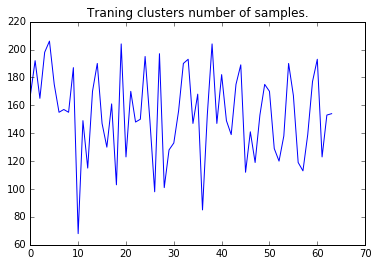

In [7]:
%matplotlib inline
plot(dist); title('Traning clusters number of samples.'); show()


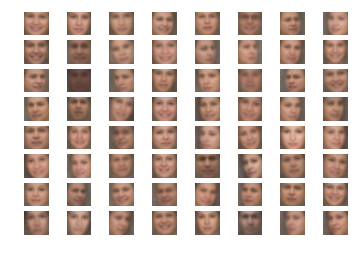

In [42]:
# plot mean image of each cluster
vec=[np.mean(_A([d.image for d in c]), axis=0).astype('uint8') for c in clusters]

z=0
rows =int(np.ceil(len(vec)**0.5))
cols =int(np.floor(len(vec)/rows))
for i in range(rows):
    for j in range(cols):
        if z<len(vec):
            subplot(rows, cols, z+1)
            imshow(cv2.cvtColor(vec[z], cv2.COLOR_BGR2RGB))
            axis("off")
        z += 1 
